In [1]:
import numpy as np 
import jax.numpy as jnp
from jax import grad, random, vmap
import optax
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio

In [2]:
X = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/churchland.npy') 
X = jnp.array(X) 
print(X.shape)

(108, 218, 61)


In [23]:
def single_pair_loss(U_tilde, X, id_1, id_2):                           #U (N,d); X(K,N,T)
    Y = jnp.einsum('i,kl->kil', U_tilde[id_1, :], X[:, id_1, :])        #(K,d,T)
    Y_prime = jnp.einsum('i,kl->kil', U_tilde[id_2, :], X[:, id_2, :])

    YY = jnp.einsum('kdt,klt->kdl', Y, Y_prime)                         #(K,d,d)
    YY_product = jnp.einsum('kij,klj->kil', YY, YY)

    S_pair = jnp.trace(YY, axis1=1, axis2=2)**2 - jnp.trace(YY_product, axis1=1, axis2=2)
    return S_pair

def loss(U, X, seed=0):  
    K, N, T = X.shape
    U_tilde, _ = jnp.linalg.qr(U)

    num_pairs = 1000  
    key = random.PRNGKey(seed)
    indices = random.randint(key, shape=(num_pairs*2,), minval=0, maxval=N)
    index_pairs = indices.reshape((num_pairs, 2))

    batched_loss = vmap(single_pair_loss, in_axes=(None, None, 0, 0))(U_tilde, X, index_pairs[:, 0], index_pairs[:, 1]) #(num_pairs, K)

    S = jnp.mean(2 / (K**2) * jnp.sum(batched_loss,axis=0))
    return -S

grad_loss = grad(loss)

def init_adam_optimizer(U_initial, learning_rate=0.001):
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(U_initial)
    return optimizer, opt_state

def update_U(U, X, optimizer, opt_state):
    dL_dU = grad_loss(U, X)
    updates, opt_state_updated = optimizer.update(dL_dU, opt_state, U)
    U_updated = optax.apply_updates(U, updates)
    return U_updated, opt_state_updated

def optimize_U(X, iterations=1000, learning_rate=0.001, d=3):
    K, N, T = X.shape
    key = random.PRNGKey(0)
    U = random.normal(key, (N, d))

    optimizer, opt_state = init_adam_optimizer(U, learning_rate)

    for i in range(iterations):
        U, opt_state = update_U(U, X, optimizer, opt_state)
        if i % 10 == 0:
            print(f"Iteration {i}, S: {-loss(U, X)}")
    
    return U

optimized_U = optimize_U(X)                     #optimized_U (N,d)

Iteration 0, S: -1718.8743896484375
Iteration 10, S: -1632.019287109375
Iteration 20, S: -1550.0556640625
Iteration 30, S: -1473.177001953125
Iteration 40, S: -1401.330322265625
Iteration 50, S: -1334.287353515625
Iteration 60, S: -1271.730712890625
Iteration 70, S: -1213.31982421875
Iteration 80, S: -1158.7235107421875
Iteration 90, S: -1107.6341552734375
Iteration 100, S: -1059.76611328125
Iteration 110, S: -1014.864013671875
Iteration 120, S: -972.6915283203125
Iteration 130, S: -933.0361938476562
Iteration 140, S: -895.7066040039062
Iteration 150, S: -860.524658203125
Iteration 160, S: -827.3318481445312
Iteration 170, S: -795.9818725585938
Iteration 180, S: -766.3417358398438
Iteration 190, S: -738.2893676757812
Iteration 200, S: -711.7136840820312
Iteration 210, S: -686.5134887695312
Iteration 220, S: -662.594482421875
Iteration 230, S: -639.8722534179688
Iteration 240, S: -618.2684936523438
Iteration 250, S: -597.709716796875
Iteration 260, S: -578.1315307617188
Iteration 270, S

In [24]:
np.save('optimized_U_test_2', optimized_U)

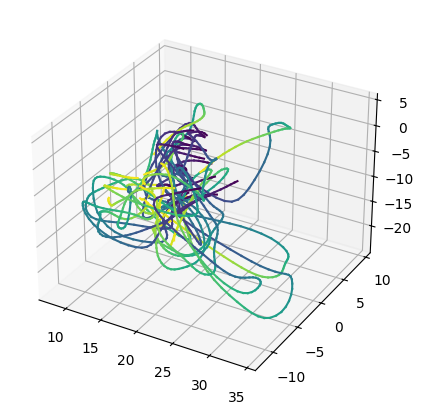

In [25]:
optimized_U_tilde, _ = jnp.linalg.qr(optimized_U)
Y = jnp.einsum('ji,kjl->kil', optimized_U_tilde, X)   


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
cmap = plt.get_cmap('viridis')

num_time_points = Y.shape[-1]
indices_to_plot = np.arange(0,Y.shape[0],5)  #[1,2,3,4,-1,-2,-3,-4]

for i in indices_to_plot:
    x = Y[i, 0, :]  
    y = Y[i, 1, :] 
    z = Y[i, 2, :]  
    
    for t in range(num_time_points - 1):
        ax.plot(x[t:t+2], y[t:t+2], z[t:t+2], color=cmap(t / (num_time_points - 1)))
